In this notebook we are estimating the error from the results got from notebook 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

from gammapy.data import DataStore

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
N_ebins = cfg['N_ebins']
zen_bins = cfg['zen_bins']
hesseras= ['hess1', 'hess2']
muoneff_flag= cfg['muoneff_flag']
bdt_edges = cfg['bdt_edges']

if muoneff_flag == False:
    print('ATTENTION, THIS SCRIPT IS MADE FOR BKG MODEL WITH MUONEFF BINNING')

model_str = cfg['model_str']
energy_bins = np.logspace(-1, 2, N_ebins+1)

if N_ebins==24:
    e_center= [0.1154782 ,  0.15399265,  0.2053525 ,  0.27384197,  0.36517413,
            0.48696753,  0.64938163,  0.86596432,  1.15478201,  1.53992656,
            2.05352501,  2.73841962,  3.65174137,  4.86967527,  6.49381614,
            8.65964312, 11.54781997, 15.3992658 , 20.53525094, 27.38419634,
           36.51741269, 48.6967522 , 64.93816094, 86.59643066]

In [5]:
def get_results(hessera):
    
    basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
    ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
    table = ds.obs_table
    
    # load results
    if hessera != 'hess1':
        file = np.loadtxt(f'results/dataspectrum_muoneff_{hessera}.txt')
        
    else:
        for idx in range(57):
            if idx==0:
                file = np.loadtxt(f'results/dataspectrum_muoneff_{hessera}_part{idx}.txt')
            else:
                file = np.concatenate((file, np.loadtxt(f'results/dataspectrum_muoneff_{hessera}_part{idx}.txt')))
    obsid_list = file[:, 0].astype(int)
    obsid_list_original = np.loadtxt(f'initial_runlist_{hessera}.txt').astype(int)
    print(f'there are {len(obsid_list_original)-len(obsid_list)}/{len(obsid_list_original)} with problems')

    # getting the error per run in units of statistical standard deviation and in units of bkg percentage
    counts=file[:, 1:N_ebins+1]
    background = file[:, N_ebins+1:]
    error_std = (counts - background)/np.sqrt(background)
    error_percentage = 100*(counts - background)/background

    #getting information of zenith and model of each run (these are the bins for error estimation)
    info = []
    for obs in obsid_list:
        idx = np.where(table['OBS_ID']==obs)[0][0]
        zen_pnt = table['ZEN_PNT'][idx]
        zen_bin = np.sum(zen_pnt > zen_bins) - 1

        muoneff = table['MUONEFF'][idx]
        if muoneff > 0.085:
            model = 0 #'B'
        elif muoneff >= 0.075:
                model = 1 # 'D'
        else:
            model = 2 #'C'

        info.append([obs, zen_pnt, zen_bin, model])
    info= np.asarray(info)

    return info, error_std, error_percentage
    
def calculate_error(info, error_std, error_percentage):
    
    def plot(res, model, zen, ax_idx):
        ax[ax_idx][zen].plot(e_center, res.T, color='lightgray');
        ax[ax_idx][zen].plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'{model_str[model]}\nN_runs={np.sum(mask)}');
        ax[ax_idx][zen].set_xscale('log')
        ax[ax_idx][zen].legend(loc='lower right')
        if ax_idx < 3:
            ax[ax_idx][zen].set_ylim(-10,10)
            if zen==0:
                ax[ax_idx][zen].set_ylabel(f'error [std]')
        else:
            ax[ax_idx][zen].set_ylim(-50,50)
            if zen==0:
                ax[ax_idx][zen].set_ylabel(f'error [bkg %]')
            

    # 7 corresponds to zen bins, 3 to 
    N_est = np.ndarray((7, 3, 1), dtype=int)
    er_est = np.ndarray((7, 3, 2, 24)) #error for 7 zenbins, 3 bkg models, 2 units of error std and percentage, 24 energy bins 
    std_est = np.ndarray((7, 3, 2, 24)) # here is the std of the error
    
    fig, ax = plt.subplots(6, 7, figsize=(3*12,24))
    for zen in range(7):
        for model in range(3):
            mask_zen = info.T[2] == zen
            mask_model = info.T[3] == model
            mask = mask_zen & mask_model
            N_est[zen][model][0] = np.sum(mask)
            
            if np.sum(mask) == 0:
                print(f'no runs for zen={zen}, model={model_str[model]}')
            else:            
                er_est[zen][model][0] = np.nanmean(error_std[mask].T, axis=1)
                er_est[zen][model][1] = np.nanmean(error_percentage[mask].T, axis=1)
                std_est[zen][model][0] = np.nanstd(error_std[mask].T, axis=1)
                std_est[zen][model][1] = np.nanstd(error_percentage[mask].T, axis=1)
                
                plot(error_std[mask], model, zen, model)
                plot(error_percentage[mask], model, zen, model+3)
    
    #this is to avoid the low statistics problem for the first zenith bin, high energies
    for i, er in enumerate(er_est[0][0][0]):
        if er > 5:
            er_est[0][0][0][i] = 0.2
            
    return N_est, er_est, std_est

# HESS1

there are 0/11342 with problems


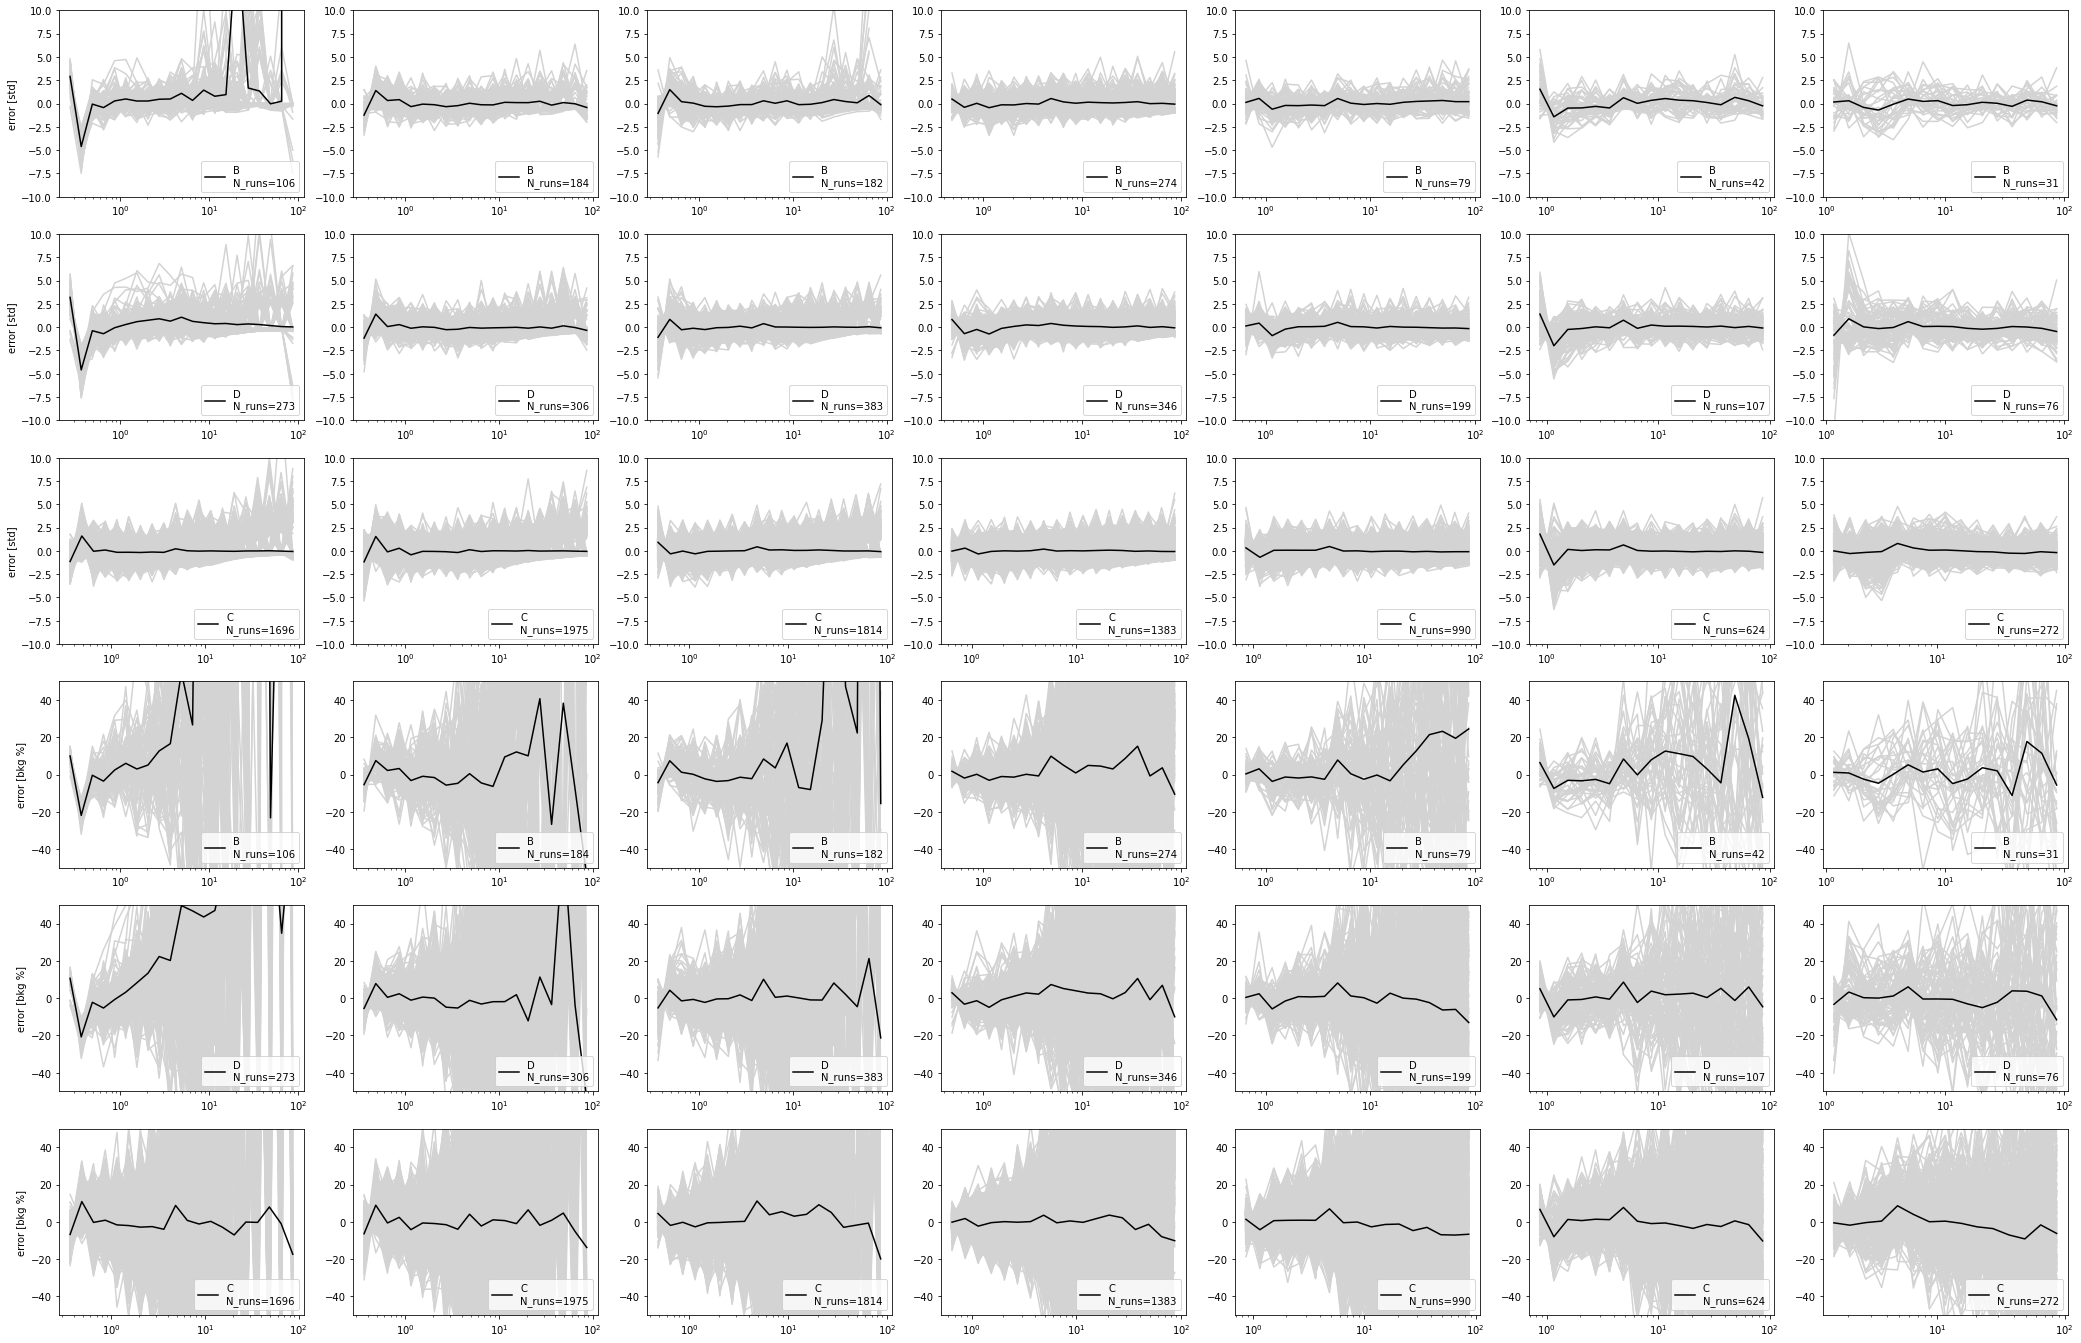

In [6]:
hessera = 'hess1'
info, error_std, error_percentage = get_results(hessera)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)

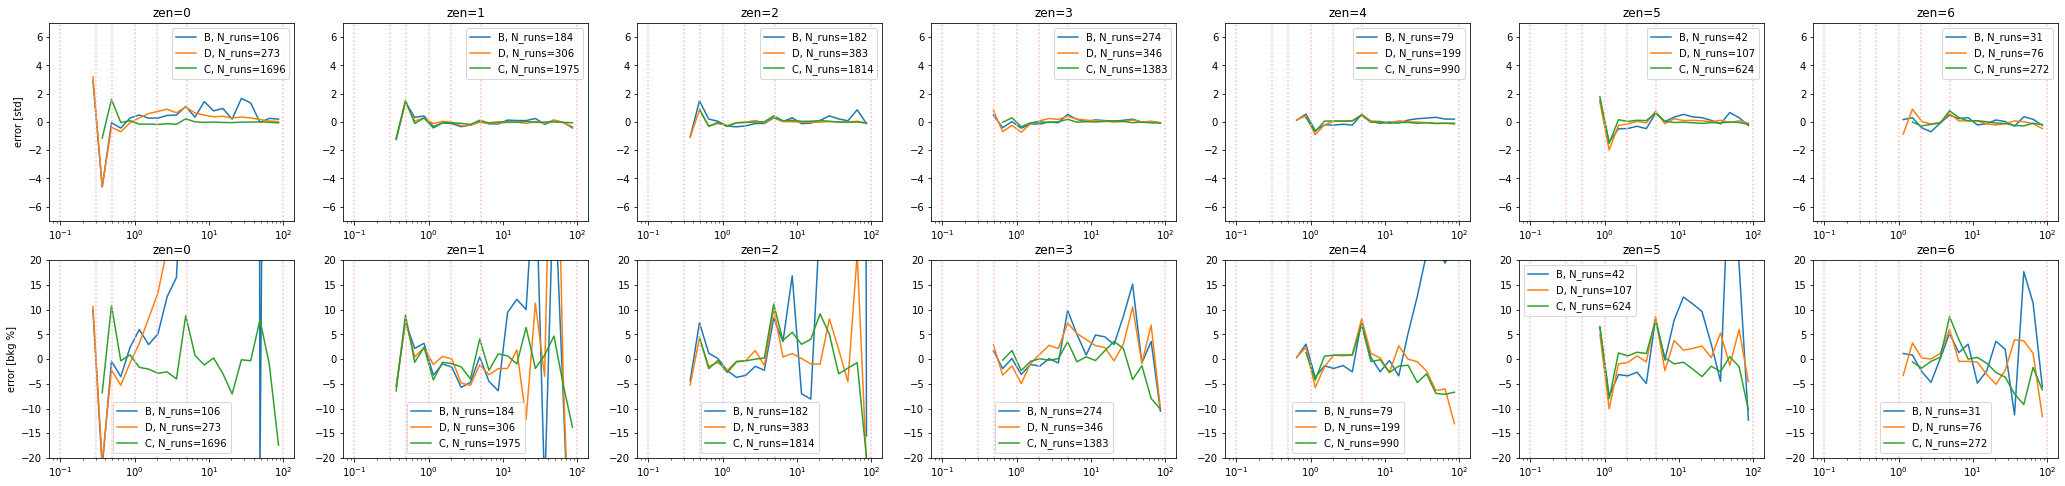

In [7]:
fig, ax = plt.subplots(2, 7, figsize=(3*12,8))    
for unit in [0, 1]:
    for zen in range(7):
        for model in range(3):
            ax[unit][zen].plot(e_center, er_est[zen][model][unit], label=f'{model_str[model]}, N_runs={N_est[zen][model][0]}')
        for bdt in bdt_edges:
            ax[unit][zen].axvline(bdt, ls=':', color='lightpink')
        ax[unit][zen].set_xscale('log')
        ax[unit][zen].legend()
        ax[unit][zen].set_title(f'zen={zen}')
        
        if unit == 0:
            ax[unit][zen].set_ylim(-7,7)
            if zen ==0:
                ax[unit][zen].set_ylabel('error [std]')
        elif unit == 1:
            ax[unit][zen].set_ylim(-20,20)
            if zen==0:
                ax[unit][zen].set_ylabel('error [bkg %]')
plt.show()

In [8]:
for model in range(3):
    np.savetxt(f'../fixed_material/{hessera}_error_estimation_{model_str[model]}.txt', er_est[:, 0, 0])

# HESS2

there are 0/2093 with problems
no runs for zen=0, model=B
no runs for zen=0, model=D
no runs for zen=1, model=B
no runs for zen=1, model=D
no runs for zen=2, model=B
no runs for zen=2, model=D
no runs for zen=3, model=B
no runs for zen=3, model=D
no runs for zen=4, model=B
no runs for zen=4, model=D
no runs for zen=5, model=B
no runs for zen=5, model=D
no runs for zen=6, model=B
no runs for zen=6, model=D


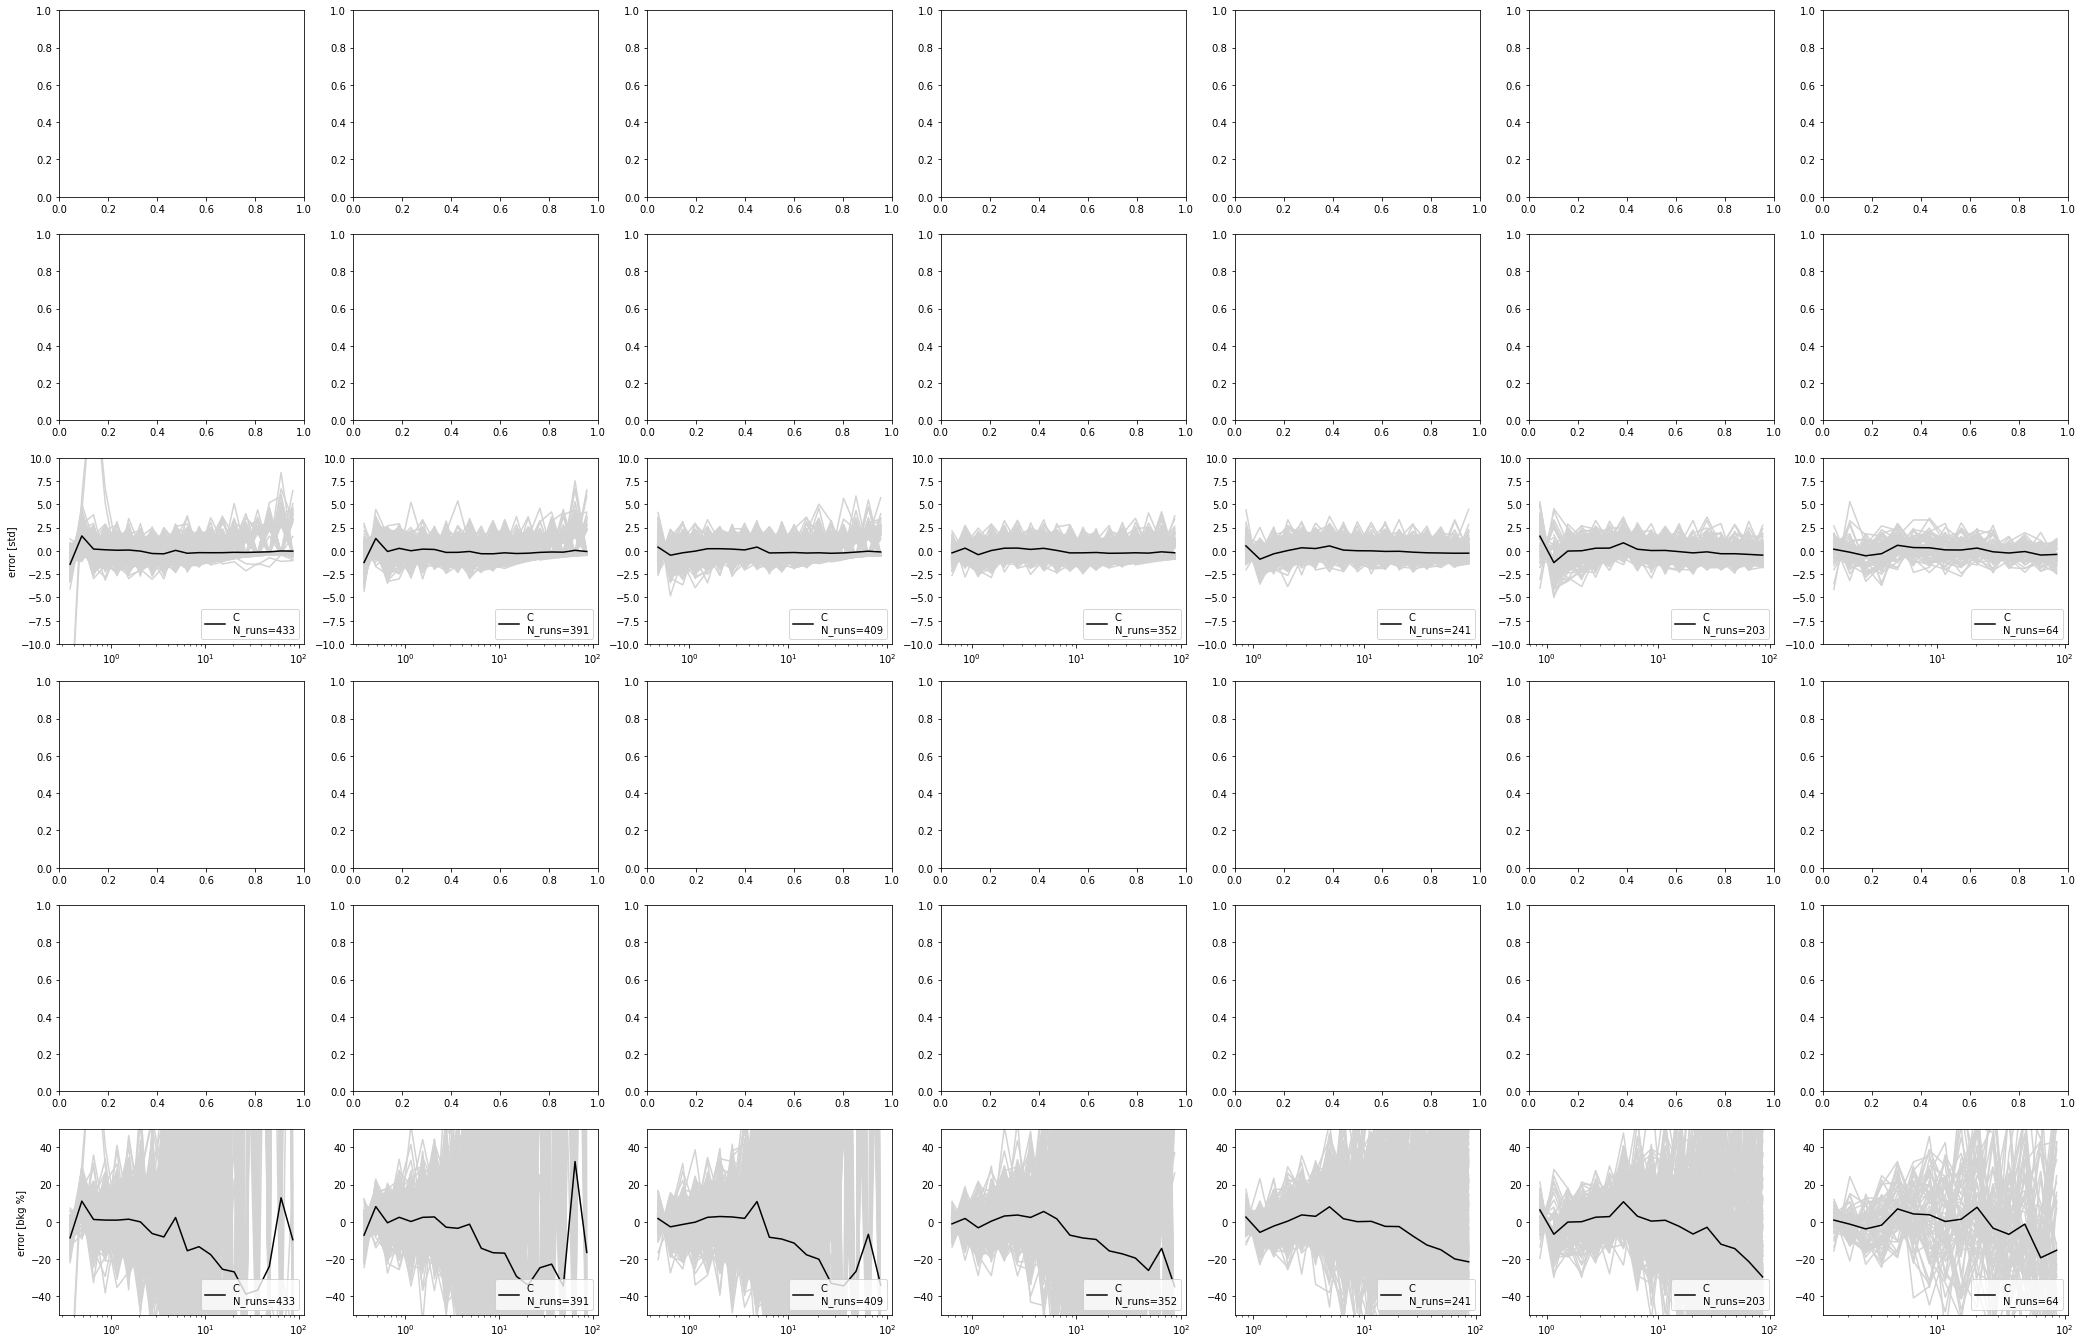

In [7]:
hessera= 'hess2'
info, error_std, error_percentage = get_results(hessera)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)

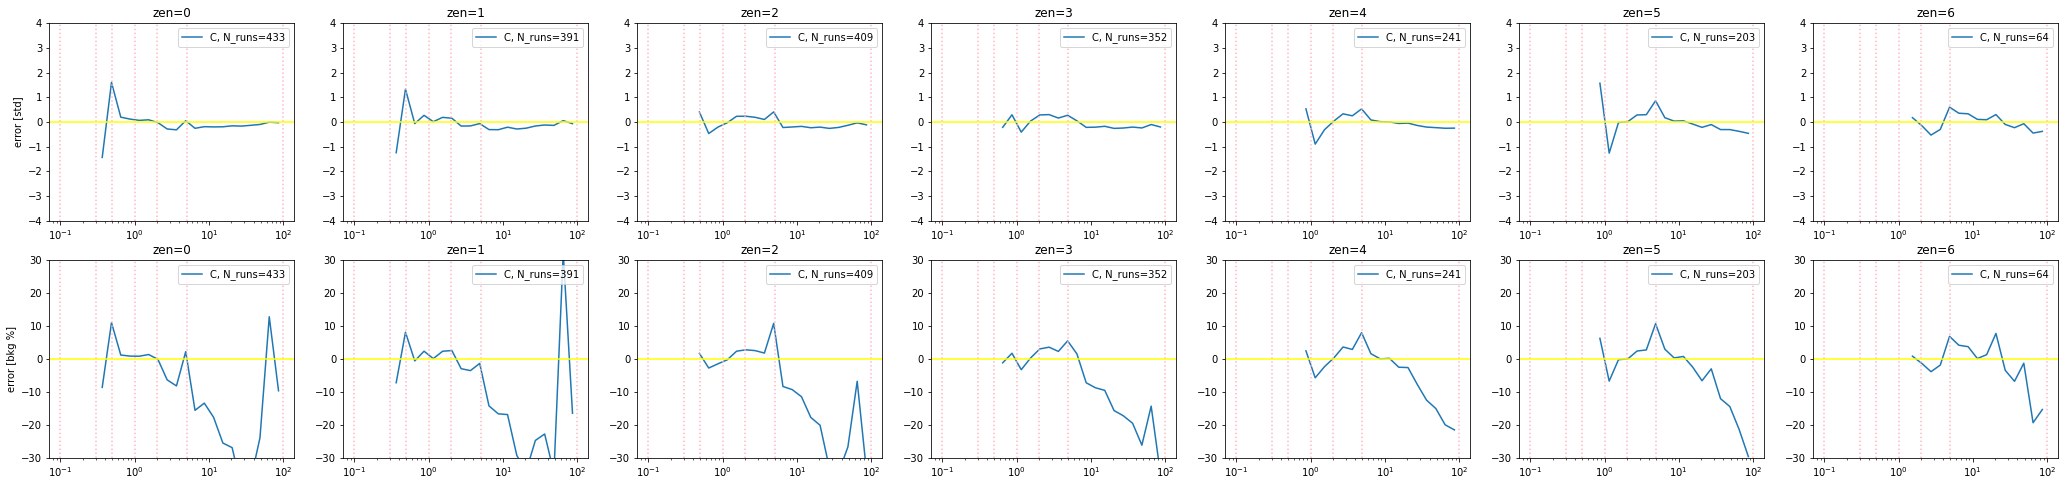

In [8]:
fig, ax = plt.subplots(2, 7, figsize=(3*12,8))    
for unit in [0, 1]:
    for zen in range(7):
        model=2
        ax[unit][zen].plot(e_center, er_est[zen][model][unit], label=f'{model_str[model]}, N_runs={N_est[zen][model][0]}')
        for bdt in bdt_edges:
            ax[unit][zen].axvline(bdt, ls=':', color='lightpink')
        ax[unit][zen].set_xscale('log')
        ax[unit][zen].axhline(0, color='yellow')
        ax[unit][zen].legend()
        ax[unit][zen].set_title(f'zen={zen}')

        if unit == 0:
            ax[unit][zen].set_ylim(-4,4)
            if zen ==0:
                ax[unit][zen].set_ylabel('error [std]')
        elif unit == 1:
            ax[unit][zen].set_ylim(-30,30)
            if zen==0:
                ax[unit][zen].set_ylabel('error [bkg %]')
plt.show()

In [9]:
for model in range(3):
    np.savetxt(f'../fixed_material/{hessera}_error_estimation_{model_str[model]}.txt', er_est[:, model, 0])